Approach: create a base model without any hyperparaeter tuning and compute MSE, RMSE.<br> From there, let's try to improve it by Feature Engineering and different models 
TODO <br>
- try with others models like MLP <br>
- try to do an stacking model, example linear regression + random forest or linear regression + MLP <br>
- study the outlier, is it a real price or it was wrongly added into the dataset <br>
more code-related:
- add unit test <br>
- try with other scaler like min-max <br>
- create a new file for helper class <br>
- all data should be into a data/ folder

In [1119]:
# internal libraries (for example if we have our helper class outside the notebook)
# Third-party imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import  GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [1120]:
class HomeListingsDataLoader:
    def __init__(self, filepath='home-listings-example.csv'):
        self.filepath = filepath
        self.df = None

    def load_dataset(self):
        """
        Load the home listings dataset without any modifications.
        """
        try:
            self.df = pd.read_csv(self.filepath)
        except FileNotFoundError:
            raise FileNotFoundError(f'File {self.filepath} not found, please provide the correct path')
        return self.df

    def preprocess_and_split(self, transformation_target_log=False):
        """
        Apply preprocessing tasks to the dataset and split into training and testing sets.
        
        Parameters:
        - transformation_target_log: Bool, whether to apply log transformation to 'ClosePrice'.
        
        Returns:
        - X_train, y_train: Training dataset split into features and target.
        - X_test, y_test: Test dataset split into features and target.
        """
        if self.df is None:
            raise ValueError("Dataset not loaded. Call load_dataset() before preprocessing.")
        
        df_processed = self.df.dropna(subset=['ClosePrice'])
        
        if transformation_target_log:
            df_processed = df_processed[df_processed['ClosePrice'] > 0]
            df_processed['ClosePrice'] = np.log(df_processed['ClosePrice'])

        mask_columns = ["ClosePrice", "BathsTotal", "BedsTotal", "CDOM", "LotSizeAreaSQFT", "SqFtTotal", "ElementarySchoolName"]
        df_processed = df_processed[mask_columns].dropna()
        df_processed['ElementarySchoolName'] = df_processed['ElementarySchoolName'].astype('category').cat.codes
        # do a Z-score normalization for the numerical columns but avoid to do it over  Bedstotal, BathsTotal, use StandardScaler
        df_processed[['CDOM', 'LotSizeAreaSQFT', 'SqFtTotal']] = scaler.fit_transform(df_processed[['CDOM', 'LotSizeAreaSQFT', 'SqFtTotal']])
        # save the processed data
        train, test = train_test_split(df_processed, test_size=0.2, random_state=42)
        X_train = train.drop('ClosePrice', axis=1)
        y_train = train['ClosePrice']
        X_test = test.drop('ClosePrice', axis=1)
        y_test = test['ClosePrice']

        return X_train, y_train, X_test, y_test


In [1121]:
homeloader_obj = HomeListingsDataLoader()
df = homeloader_obj.load_dataset()[['ClosePrice', 'BathsTotal', 'BedsTotal', 'CDOM', 'LotSizeAreaSQFT', 'SqFtTotal', 'ElementarySchoolName']]

/var/folders/27/rct05ybx0ps6hwtj48shph300000gn/T/ipykernel_1405/3680418057.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


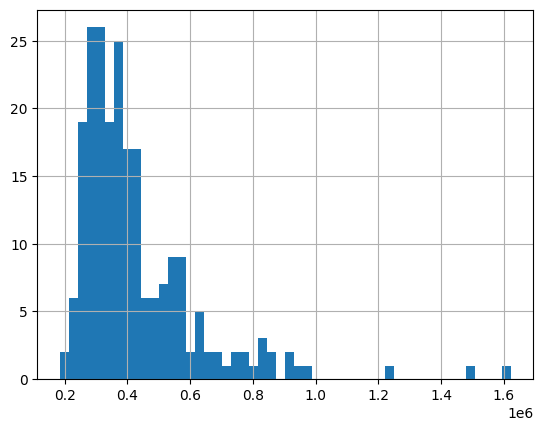

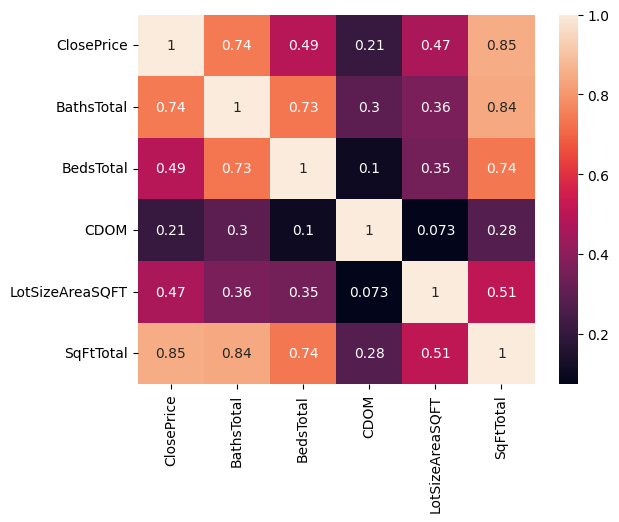

In [1122]:
# do a correlation matrix to see which features are most correlated with the target, only take
correlation_matrix = df.corr()
correlation_matrix
correlation_matrix["ClosePrice"].sort_values(ascending=False)
# then do a histogram of the target variable
df["ClosePrice"].hist(bins=50)
plt.show()
# show a heat map of the correlation matrix
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True)
plt.show()


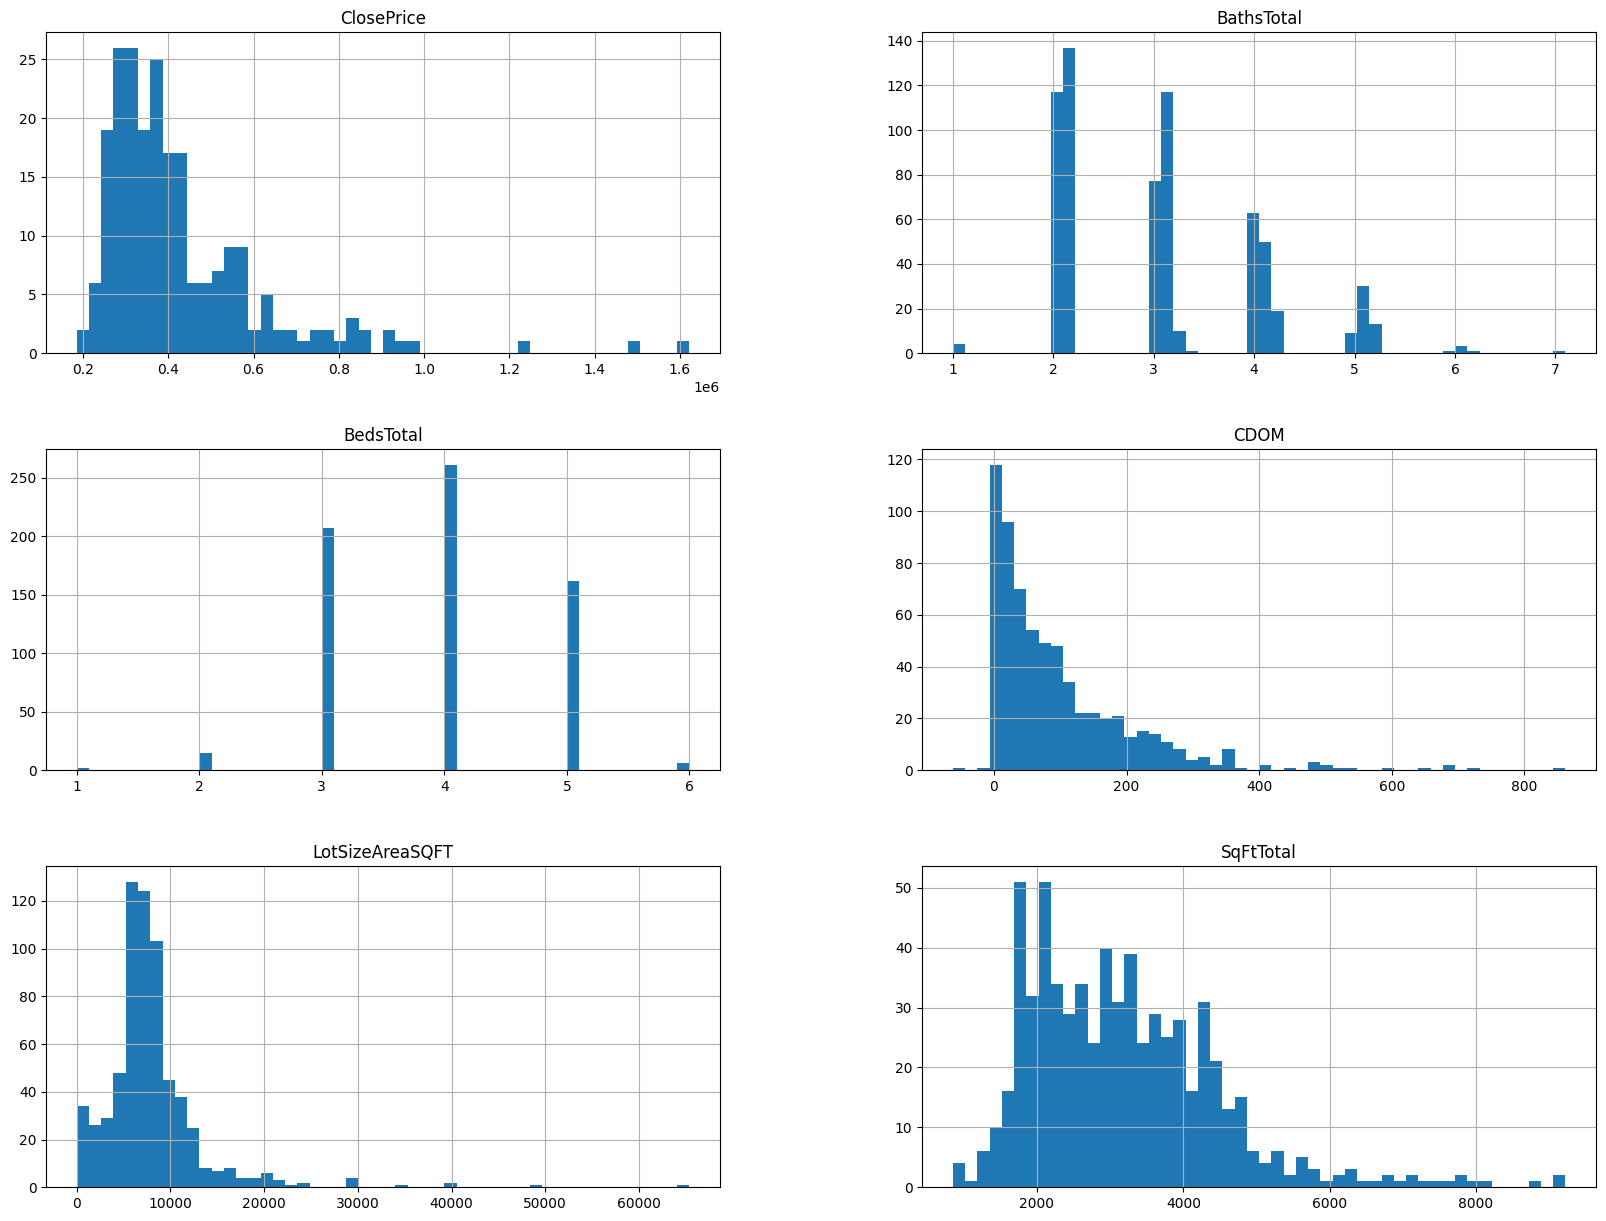

In [1123]:
# check distribution of for the each feature in the dataset only use 1 graph
df.hist(bins=50, figsize=(20,15))
plt.show()
    

In [1124]:
X_train, y_train, X_test, y_test = homeloader_obj.preprocess_and_split()
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
# look at the coefficients of the model with names of the features
print(model.coef_)
print(X_train.columns)



MSE: 7901336542.105
RMSE: 88889.46249193433
[ 53623.41891578 -71545.51995052  -4285.04699012  60258.34743336
 145705.83242854   -346.57708601]
Index(['BathsTotal', 'BedsTotal', 'CDOM', 'LotSizeAreaSQFT', 'SqFtTotal',
       'ElementarySchoolName'],
      dtype='object')


We are going to try to improve MSE: MS by doing log transformation over the ClosePrice and GridSearchCV and CV.

MSE: 5453464900.97976
RMSE: 73847.57884304509


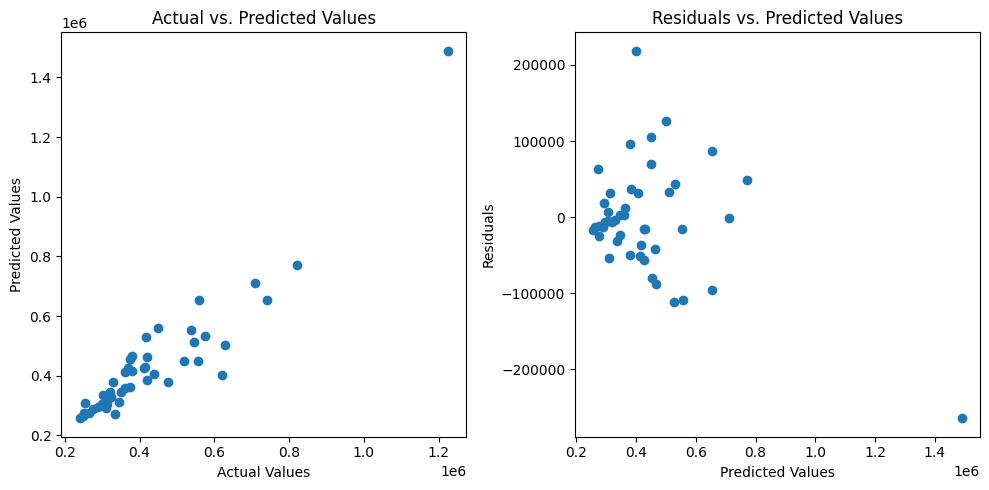

In [1125]:
# Load data and apply initial transformations
X_train, y_train, X_test, y_test = homeloader_obj.preprocess_and_split(True)

# Setup the pipeline and grid search for linear regression
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', LinearRegression())
])
param_grid = {
    'model__fit_intercept': [True, False]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Predict and apply inverse log transformation to both predicted and test target values
y_pred = np.exp(grid_search.predict(X_test))
y_test_exp = np.exp(y_test)

# Calculate and print MSE and RMSE
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE:', rmse)

# Visualize results with a scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_exp, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

# Visualize residuals with a scatter plot of predicted values vs. residuals
residuals = y_test_exp - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.tight_layout()
plt.show()


MSE: 5425288574.1745405
RMSE: 73656.55825637348


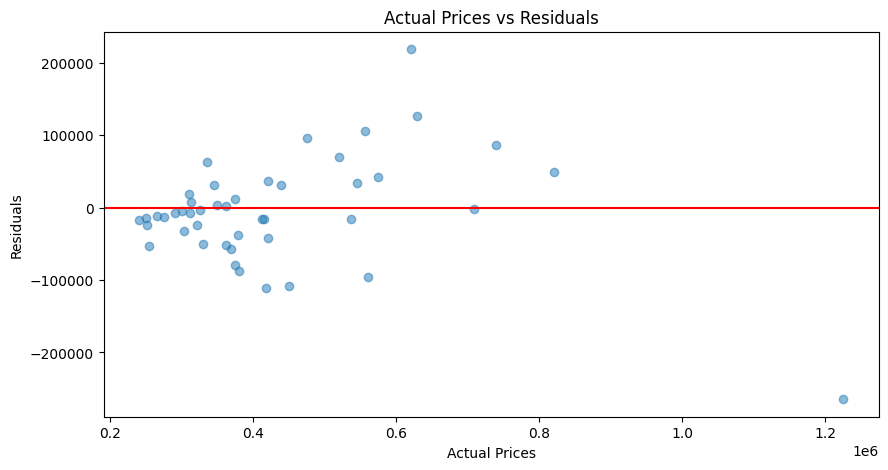

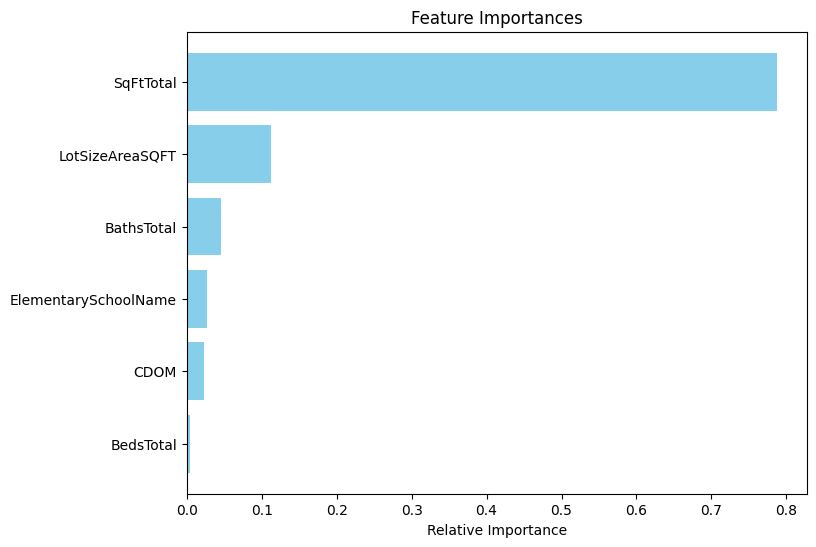

In [1126]:
# Load data and apply log transformation
X_train, y_train, X_test, y_test = homeloader_obj.preprocess_and_split(True)

# Define parameter grid for Random Forest regressor
param_grid = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a Random Forest regressor with GridSearchCV to tune hyperparameters
model = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the test set results and invert the log transformation
y_pred = np.exp(model.predict(X_test))
y_test_exp = np.exp(y_test)  # Ensure y_test is also transformed back

# Calculate and print the Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test_exp, y_pred)
rmse = np.sqrt(mse)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot residuals to analyze the variance in predictions
plt.figure(figsize=(10, 5))
plt.scatter(y_test_exp, residuals, alpha=0.5)
plt.xlabel('Actual Prices')
plt.ylabel('Residuals')
plt.title('Actual Prices vs Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Visualize feature importances from the Random Forest model
importances = model.best_estimator_.feature_importances_
features = X_train.columns
indices = np.argsort(importances)

# Create a horizontal bar chart for feature importances
plt.figure(figsize=(8, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
